In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# import attention_conv.model as modelsrc
import unet.model as modelsrc
# import stupid_simple_conv.model as modelsrc
from main_dataset import CHMainDataset, SingleCropGenerator
from chunkified_npset import ChunkifiedDataset
from loss import MS_SSIMLoss
import os
import imp
import pickle
from datetime import datetime

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
imp.reload(modelsrc)
ModelToTest = modelsrc.UNetDeep
params = []

Training Setup

In [4]:
BATCH_LEN = 32 #still depends on its_til_update for true loss batch size
EPOCHS = 100

Training utilities
# wow

Training loop definition

In [5]:
dir_to_save = 'other_state_dicts/unetdeep'
if not os.path.isdir(dir_to_save):
    os.makedirs(dir_to_save)

In [6]:
def train_epoch(dataloader, model, optimizer, criterion, losses, epoch_losses, epoch, name_list):
    its_til_checkpoint = 20
    its_til_cleanup = 200
    its_til_update = 1
    
    epoch_running_loss = 0
    epoch_count = 0
    running_loss = 0
    count = 0
    optimizer.zero_grad()
    model.train()
    for i, (features, targets) in enumerate(dataloader):
        features = features.to(device)
        targets = targets.to(device)

        predictions = model(features)

        loss = criterion(predictions.unsqueeze(2), targets.unsqueeze(2))
        loss.backward()

        curr_len = features.shape[0]
        running_loss += curr_len * loss.item()
        count += curr_len
        epoch_running_loss += curr_len * loss.item()
        epoch_count += curr_len
        
        losses.append(loss.item())
        
        if i % its_til_update == its_til_update-1:
            print(f'Peforming update on model with batch_size - {its_til_update * BATCH_LEN}')
            optimizer.step()
            optimizer.zero_grad()
        
        print(f'Iteration {i} - batch size: {curr_len}')
        
        if i % its_til_checkpoint == its_til_checkpoint-1:
            curr_loss = running_loss / count
            print(f'Current loss after {its_til_checkpoint} iterations: {curr_loss}')

            plt.plot(losses, 'b-')
            plt.title("Loss over iterations")
            plt.show()

            file_name = f'epoch-{epoch}_iteration-{i}_loss-{curr_loss}'
            torch.save(model.state_dict(), os.path.join(dir_to_save, file_name))
            name_list.append(file_name)

            running_loss = 0
            count = 0
        
        if i % its_til_cleanup == its_til_cleanup - 1:
            #remove old entries
            for name in name_list[:-8]:
                path = os.path.join(dir_to_save, name)
                if os.path.isfile(path):
                    os.remove(path)
            name_list = name_list[-8:]
            
        if i == 1440: #rando early break lul
            break
    
    epoch_losses.append(epoch_running_loss / epoch_count)

In [7]:
def train(epochs, dataset, batch_size, model, optimizer, criterion):
    losses = []
    epoch_losses = []
    dataloader = DataLoader(dataset, batch_size=batch_size)
    name_list = []
    try:
        for epoch in range(epochs):
            print(f'Entering epoch {epoch}')
            train_epoch(dataloader, model, optimizer, criterion, losses, epoch_losses, epoch, name_list)
            print(f'Loss for epoch {epoch} - {epoch_losses[-1]}')
            plt.plot(epoch_losses, 'r-')
            plt.title('Epoch Losses')
            plt.show()

            #remove old entries
            for name in name_list[:-5]:
                path = os.path.join(dir_to_save, name)
                if os.path.isfile(path):
                    os.remove(path)
            name_list = name_list[-5:]

            with open(os.path.join(dir_to_save, 'epoch_losses'), 'wb') as f:
                pickle.dump(epoch_losses, f)
            f.close()
    except Exception as e: #catch any error and log em!
        with open(os.path.join(dir_to_save, 'error.txt'), 'a') as f:
            f.write(str(e))
        f.close()
    
    # time of finish
    with open(os.path.join(dir_to_save, 'time_of_finish.txt'), 'a') as f:
        now = datetime.now()
        dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
        f.write(dt_string)
    f.close()
    
    return losses

In [8]:
np_set = ChunkifiedDataset()
gen = SingleCropGenerator(np_set[0].shape[0], np_set[0].shape[1])
dataset = CHMainDataset(np_set, gen)
dataset[0][1].shape

(24, 64, 64)

In [9]:
# preprocess = ImagesPreprocess()
# model = PerceiverCH(preprocess, latent_dim=(32, 128), heads=8, wide_factor=4, latent_count=6)
model = ModelToTest()
model.to(device)
msssim = MS_SSIMLoss(channels=24)
l1 = torch.nn.L1Loss()
criterion = lambda pred, target: msssim(pred,target) #+ l1(pred,target) 

Entering epoch 0
Peforming update on model with batch_size - 32
Iteration 0 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 2 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 3 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 4 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 5 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 6 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 7 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 8 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 9 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 10 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 11 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 12 - batch s

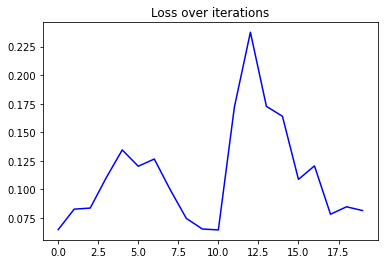

Peforming update on model with batch_size - 32
Iteration 20 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 21 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 22 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 23 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 24 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 25 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 26 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 27 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 28 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 29 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 30 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 31 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 32 - batch size: 32

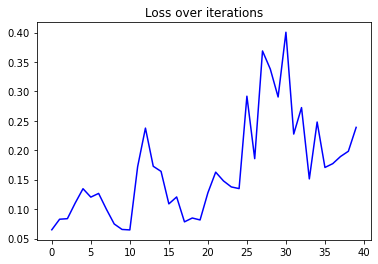

Peforming update on model with batch_size - 32
Iteration 40 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 41 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 42 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 43 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 44 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 45 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 46 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 47 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 48 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 49 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 50 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 51 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 52 - batch size: 32

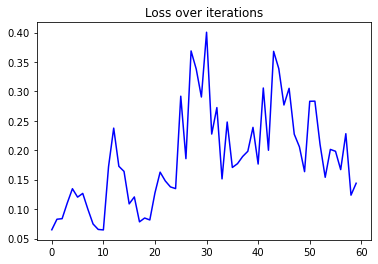

Peforming update on model with batch_size - 32
Iteration 60 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 61 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 62 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 63 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 64 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 65 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 66 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 67 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 68 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 69 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 70 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 71 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 72 - batch size: 32

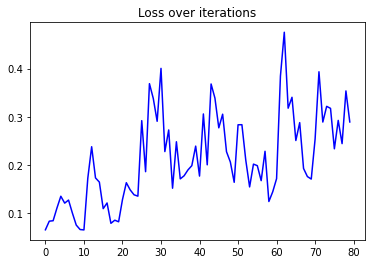

Peforming update on model with batch_size - 32
Iteration 80 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 81 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 82 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 83 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 84 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 85 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 86 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 87 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 88 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 89 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 90 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 91 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 92 - batch size: 32

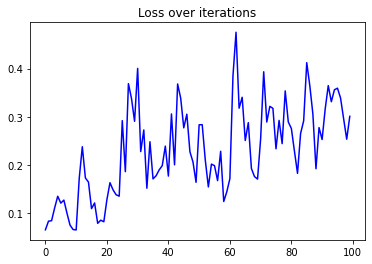

Peforming update on model with batch_size - 32
Iteration 100 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 101 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 102 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 103 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 104 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 105 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 106 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 107 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 108 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 109 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 110 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 111 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 112 - b

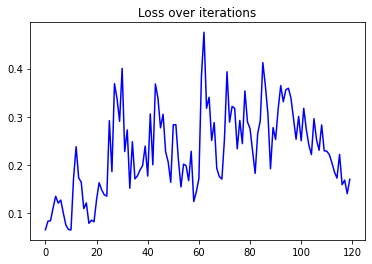

Peforming update on model with batch_size - 32
Iteration 120 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 121 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 122 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 123 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 124 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 125 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 126 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 127 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 128 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 129 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 130 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 131 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 132 - b

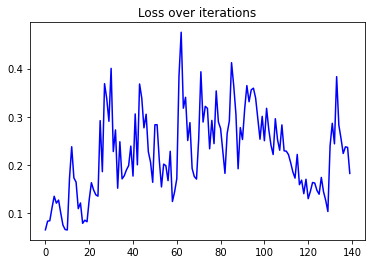

Peforming update on model with batch_size - 32
Iteration 140 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 141 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 142 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 143 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 144 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 145 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 146 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 147 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 148 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 149 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 150 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 151 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 152 - b

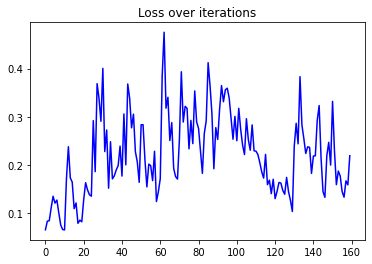

Peforming update on model with batch_size - 32
Iteration 160 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 161 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 162 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 163 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 164 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 165 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 166 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 167 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 168 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 169 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 170 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 171 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 172 - b

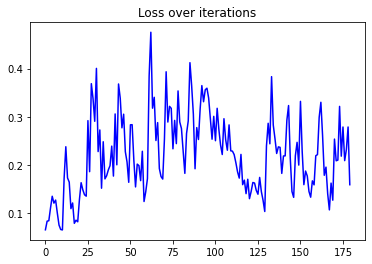

Peforming update on model with batch_size - 32
Iteration 180 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 181 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 182 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 183 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 184 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 185 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 186 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 187 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 188 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 189 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 190 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 191 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 192 - b

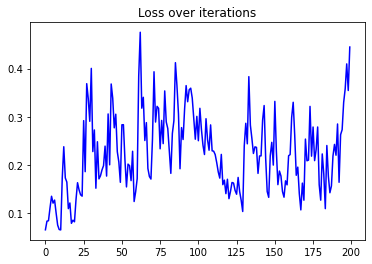

Peforming update on model with batch_size - 32
Iteration 200 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 201 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 202 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 203 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 204 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 205 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 206 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 207 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 208 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 209 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 210 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 211 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 212 - b

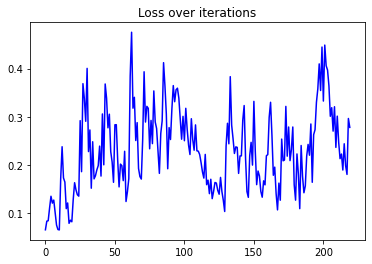

Peforming update on model with batch_size - 32
Iteration 220 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 221 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 222 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 223 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 224 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 225 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 226 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 227 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 228 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 229 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 230 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 231 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 232 - b

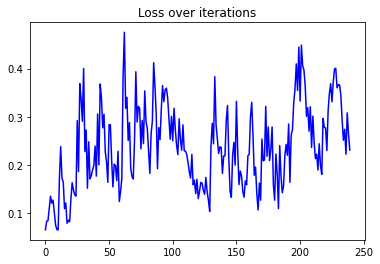

Peforming update on model with batch_size - 32
Iteration 240 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 241 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 242 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 243 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 244 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 245 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 246 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 247 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 248 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 249 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 250 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 251 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 252 - b

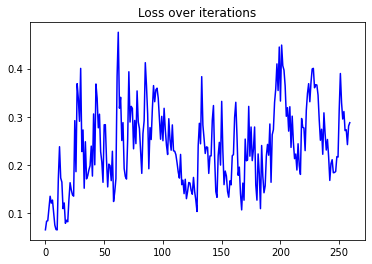

Peforming update on model with batch_size - 32
Iteration 260 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 261 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 262 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 263 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 264 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 265 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 266 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 267 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 268 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 269 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 270 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 271 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 272 - b

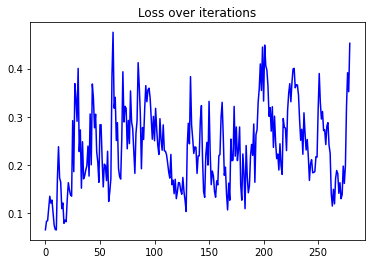

Peforming update on model with batch_size - 32
Iteration 280 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 281 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 282 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 283 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 284 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 285 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 286 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 287 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 288 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 289 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 290 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 291 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 292 - b

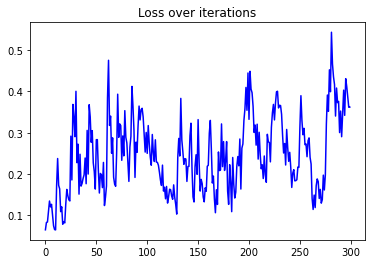

Peforming update on model with batch_size - 32
Iteration 300 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 301 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 302 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 303 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 304 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 305 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 306 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 307 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 308 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 309 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 310 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 311 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 312 - b

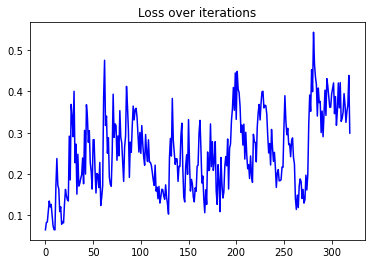

Peforming update on model with batch_size - 32
Iteration 320 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 321 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 322 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 323 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 324 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 325 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 326 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 327 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 328 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 329 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 330 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 331 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 332 - b

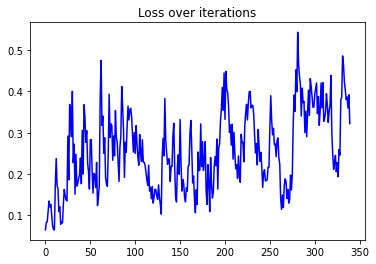

Peforming update on model with batch_size - 32
Iteration 340 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 341 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 342 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 343 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 344 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 345 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 346 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 347 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 348 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 349 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 350 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 351 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 352 - b

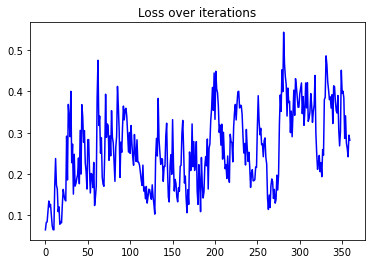

Peforming update on model with batch_size - 32
Iteration 360 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 361 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 362 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 363 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 364 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 365 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 366 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 367 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 368 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 369 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 370 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 371 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 372 - b

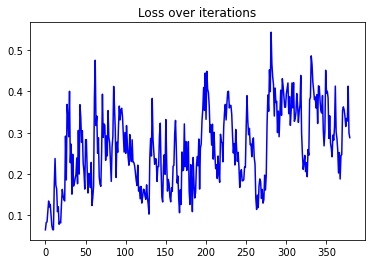

Peforming update on model with batch_size - 32
Iteration 380 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 381 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 382 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 383 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 384 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 385 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 386 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 387 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 388 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 389 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 390 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 391 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 392 - b

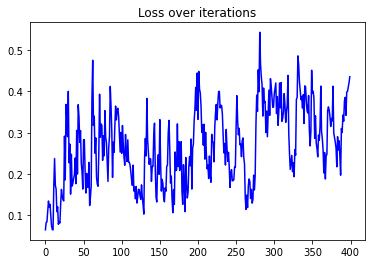

Peforming update on model with batch_size - 32
Iteration 400 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 401 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 402 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 403 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 404 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 405 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 406 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 407 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 408 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 409 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 410 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 411 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 412 - b

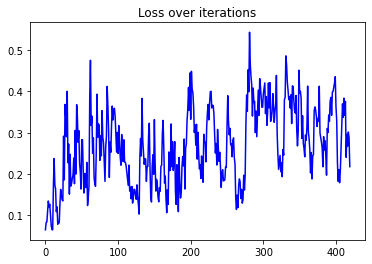

Peforming update on model with batch_size - 32
Iteration 420 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 421 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 422 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 423 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 424 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 425 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 426 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 427 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 428 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 429 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 430 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 431 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 432 - b

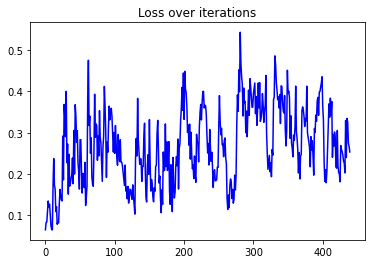

Peforming update on model with batch_size - 32
Iteration 440 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 441 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 442 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 443 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 444 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 445 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 446 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 447 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 448 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 449 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 450 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 451 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 452 - b

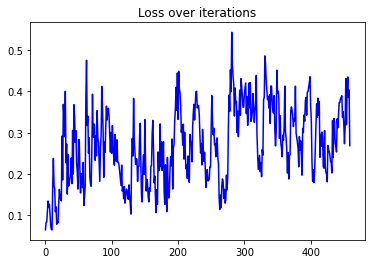

Peforming update on model with batch_size - 32
Iteration 460 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 461 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 462 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 463 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 464 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 465 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 466 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 467 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 468 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 469 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 470 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 471 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 472 - b

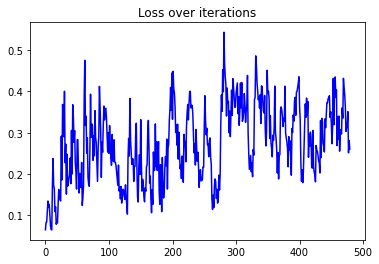

Peforming update on model with batch_size - 32
Iteration 480 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 481 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 482 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 483 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 484 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 485 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 486 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 487 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 488 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 489 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 490 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 491 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 492 - b

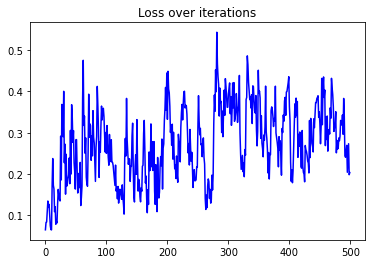

Peforming update on model with batch_size - 32
Iteration 500 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 501 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 502 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 503 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 504 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 505 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 506 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 507 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 508 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 509 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 510 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 511 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 512 - b

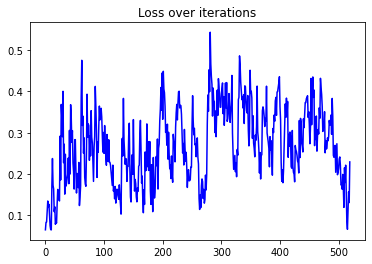

Peforming update on model with batch_size - 32
Iteration 520 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 521 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 522 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 523 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 524 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 525 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 526 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 527 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 528 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 529 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 530 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 531 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 532 - b

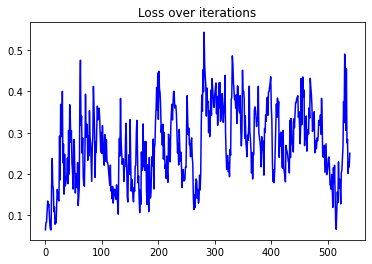

Peforming update on model with batch_size - 32
Iteration 540 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 541 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 542 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 543 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 544 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 545 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 546 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 547 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 548 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 549 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 550 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 551 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 552 - b

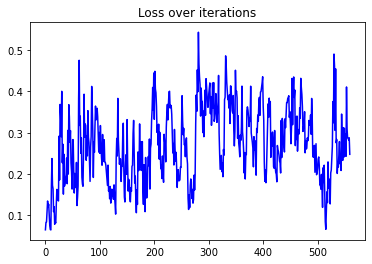

Peforming update on model with batch_size - 32
Iteration 560 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 561 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 562 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 563 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 564 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 565 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 566 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 567 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 568 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 569 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 570 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 571 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 572 - b

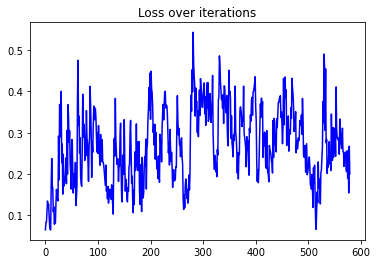

Peforming update on model with batch_size - 32
Iteration 580 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 581 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 582 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 583 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 584 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 585 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 586 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 587 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 588 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 589 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 590 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 591 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 592 - b

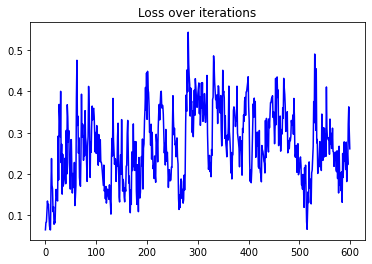

Peforming update on model with batch_size - 32
Iteration 600 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 601 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 602 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 603 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 604 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 605 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 606 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 607 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 608 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 609 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 610 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 611 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 612 - b

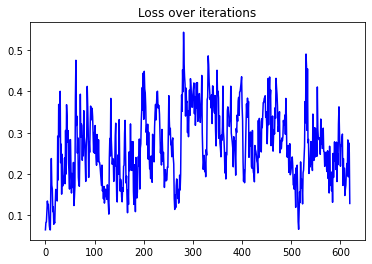

Peforming update on model with batch_size - 32
Iteration 620 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 621 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 622 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 623 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 624 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 625 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 626 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 627 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 628 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 629 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 630 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 631 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 632 - b

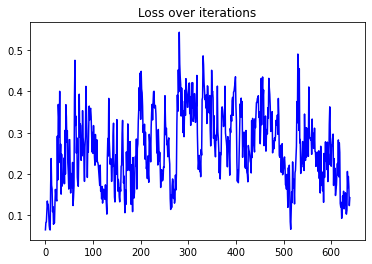

Peforming update on model with batch_size - 32
Iteration 640 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 641 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 642 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 643 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 644 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 645 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 646 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 647 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 648 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 649 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 650 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 651 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 652 - b

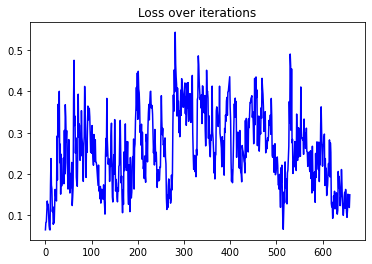

Peforming update on model with batch_size - 32
Iteration 660 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 661 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 662 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 663 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 664 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 665 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 666 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 667 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 668 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 669 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 670 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 671 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 672 - b

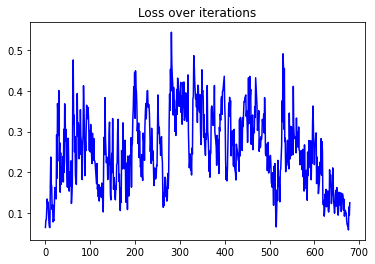

Peforming update on model with batch_size - 32
Iteration 680 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 681 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 682 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 683 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 684 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 685 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 686 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 687 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 688 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 689 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 690 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 691 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 692 - b

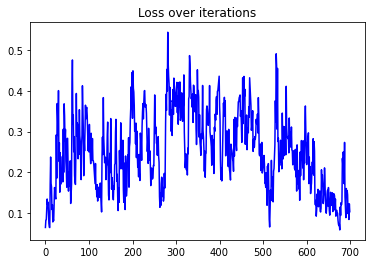

Peforming update on model with batch_size - 32
Iteration 700 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 701 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 702 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 703 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 704 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 705 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 706 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 707 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 708 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 709 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 710 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 711 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 712 - b

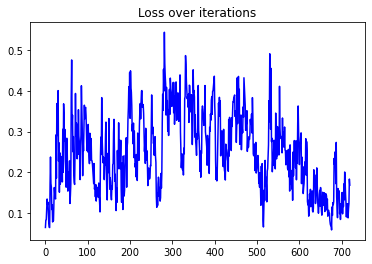

Peforming update on model with batch_size - 32
Iteration 720 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 721 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 722 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 723 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 724 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 725 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 726 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 727 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 728 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 729 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 730 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 731 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 732 - b

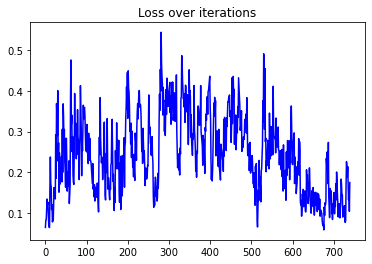

Peforming update on model with batch_size - 32
Iteration 740 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 741 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 742 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 743 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 744 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 745 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 746 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 747 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 748 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 749 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 750 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 751 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 752 - b

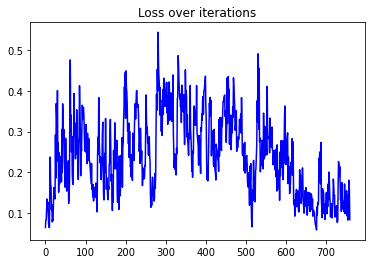

Peforming update on model with batch_size - 32
Iteration 760 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 761 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 762 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 763 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 764 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 765 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 766 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 767 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 768 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 769 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 770 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 771 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 772 - b

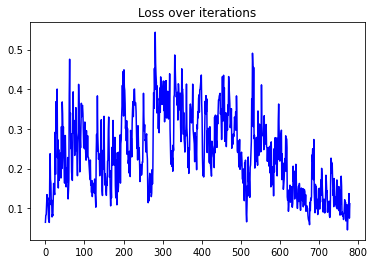

Peforming update on model with batch_size - 32
Iteration 780 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 781 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 782 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 783 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 784 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 785 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 786 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 787 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 788 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 789 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 790 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 791 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 792 - b

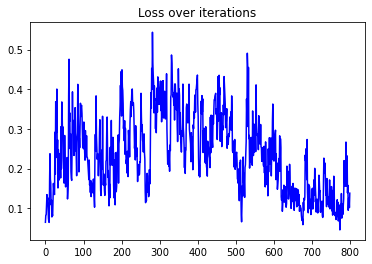

Peforming update on model with batch_size - 32
Iteration 800 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 801 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 802 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 803 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 804 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 805 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 806 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 807 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 808 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 809 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 810 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 811 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 812 - b

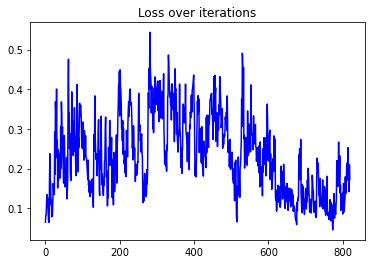

Peforming update on model with batch_size - 32
Iteration 820 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 821 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 822 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 823 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 824 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 825 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 826 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 827 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 828 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 829 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 830 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 831 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 832 - b

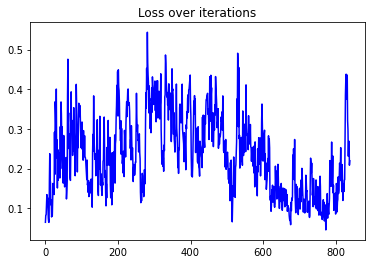

Peforming update on model with batch_size - 32
Iteration 840 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 841 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 842 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 843 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 844 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 845 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 846 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 847 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 848 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 849 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 850 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 851 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 852 - b

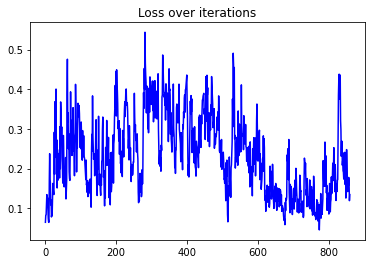

Peforming update on model with batch_size - 32
Iteration 860 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 861 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 862 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 863 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 864 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 865 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 866 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 867 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 868 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 869 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 870 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 871 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 872 - b

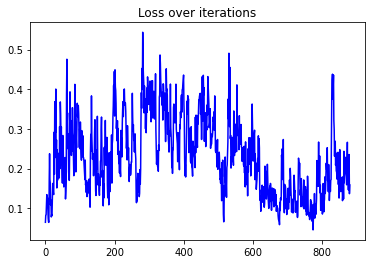

Peforming update on model with batch_size - 32
Iteration 880 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 881 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 882 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 883 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 884 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 885 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 886 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 887 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 888 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 889 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 890 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 891 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 892 - b

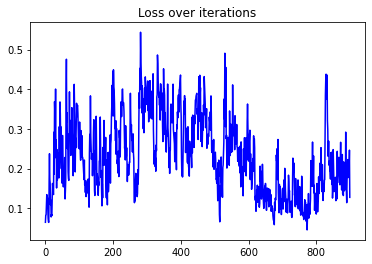

Peforming update on model with batch_size - 32
Iteration 900 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 901 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 902 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 903 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 904 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 905 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 906 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 907 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 908 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 909 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 910 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 911 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 912 - b

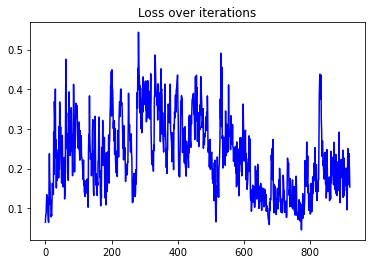

Peforming update on model with batch_size - 32
Iteration 920 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 921 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 922 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 923 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 924 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 925 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 926 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 927 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 928 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 929 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 930 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 931 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 932 - b

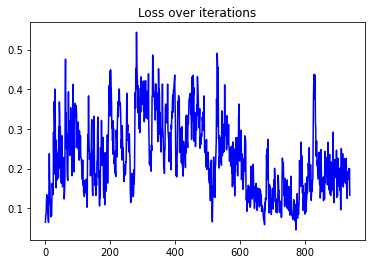

Peforming update on model with batch_size - 32
Iteration 940 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 941 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 942 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 943 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 944 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 945 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 946 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 947 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 948 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 949 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 950 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 951 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 952 - b

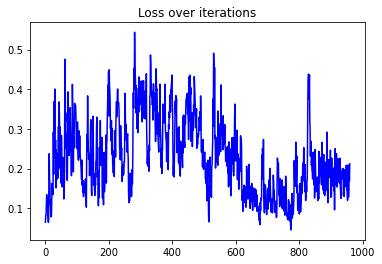

Peforming update on model with batch_size - 32
Iteration 960 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 961 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 962 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 963 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 964 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 965 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 966 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 967 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 968 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 969 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 970 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 971 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 972 - b

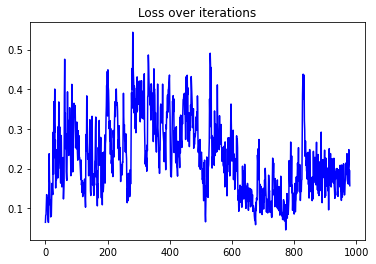

Peforming update on model with batch_size - 32
Iteration 980 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 981 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 982 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 983 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 984 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 985 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 986 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 987 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 988 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 989 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 990 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 991 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 992 - b

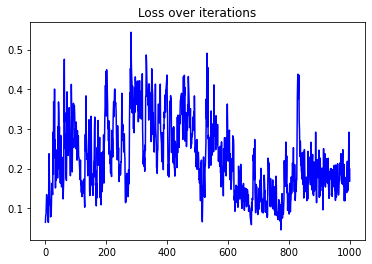

Peforming update on model with batch_size - 32
Iteration 1000 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1001 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1002 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1003 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1004 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1005 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1006 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1007 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1008 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1009 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1010 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1011 - batch size: 32
Peforming update on model with batch_size - 32
Itera

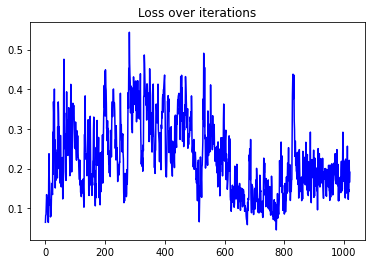

Peforming update on model with batch_size - 32
Iteration 1020 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1021 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1022 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1023 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1024 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1025 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1026 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1027 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1028 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1029 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1030 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1031 - batch size: 32
Peforming update on model with batch_size - 32
Itera

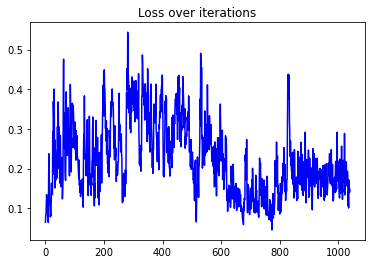

Peforming update on model with batch_size - 32
Iteration 1040 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1041 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1042 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1043 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1044 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1045 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1046 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1047 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1048 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1049 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1050 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1051 - batch size: 32
Peforming update on model with batch_size - 32
Itera

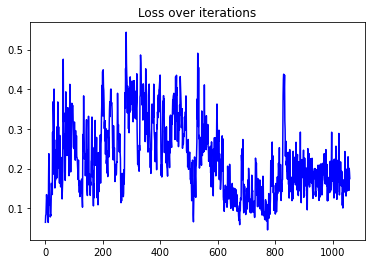

Peforming update on model with batch_size - 32
Iteration 1060 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1061 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1062 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1063 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1064 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1065 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1066 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1067 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1068 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1069 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1070 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1071 - batch size: 32
Peforming update on model with batch_size - 32
Itera

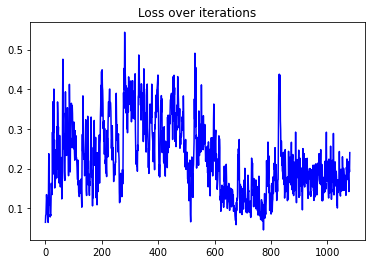

Peforming update on model with batch_size - 32
Iteration 1080 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1081 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1082 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1083 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1084 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1085 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1086 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1087 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1088 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1089 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1090 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1091 - batch size: 32
Peforming update on model with batch_size - 32
Itera

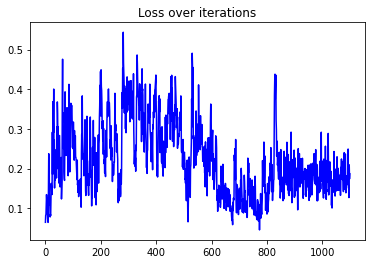

Peforming update on model with batch_size - 32
Iteration 1100 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1101 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1102 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1103 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1104 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1105 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1106 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1107 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1108 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1109 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1110 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1111 - batch size: 32
Peforming update on model with batch_size - 32
Itera

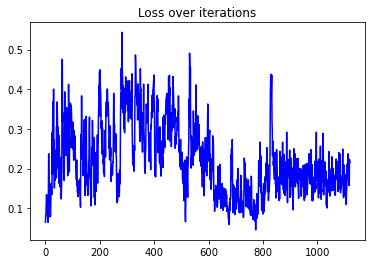

Peforming update on model with batch_size - 32
Iteration 1120 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1121 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1122 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1123 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1124 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1125 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1126 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1127 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1128 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1129 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1130 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1131 - batch size: 32
Peforming update on model with batch_size - 32
Itera

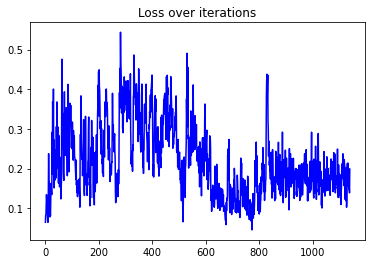

Peforming update on model with batch_size - 32
Iteration 1140 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1141 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1142 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1143 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1144 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1145 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1146 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1147 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1148 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1149 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1150 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1151 - batch size: 32
Peforming update on model with batch_size - 32
Itera

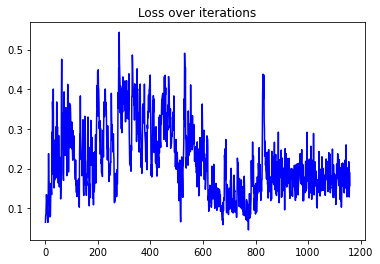

Peforming update on model with batch_size - 32
Iteration 1160 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1161 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1162 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1163 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1164 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1165 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1166 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1167 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1168 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1169 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1170 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1171 - batch size: 32
Peforming update on model with batch_size - 32
Itera

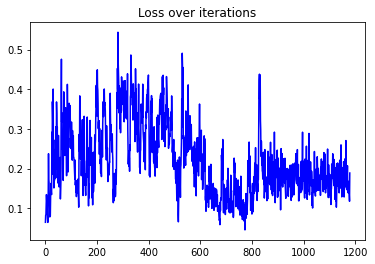

Peforming update on model with batch_size - 32
Iteration 1180 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1181 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1182 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1183 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1184 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1185 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1186 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1187 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1188 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1189 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1190 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1191 - batch size: 32
Peforming update on model with batch_size - 32
Itera

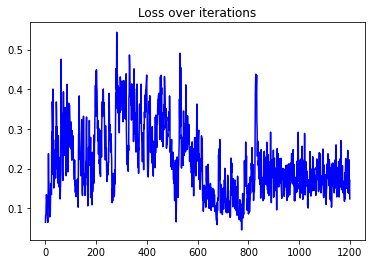

Peforming update on model with batch_size - 32
Iteration 1200 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1201 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1202 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1203 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1204 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1205 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1206 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1207 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1208 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1209 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1210 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1211 - batch size: 32
Peforming update on model with batch_size - 32
Itera

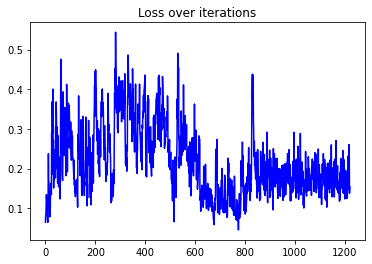

Peforming update on model with batch_size - 32
Iteration 1220 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1221 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1222 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1223 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1224 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1225 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1226 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1227 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1228 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1229 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1230 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1231 - batch size: 32
Peforming update on model with batch_size - 32
Itera

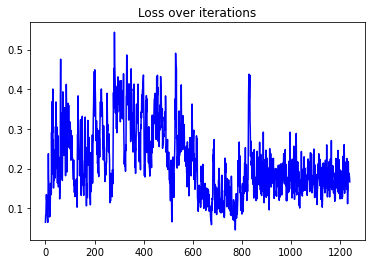

Peforming update on model with batch_size - 32
Iteration 1240 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1241 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1242 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1243 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1244 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1245 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1246 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1247 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1248 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1249 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1250 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1251 - batch size: 32
Peforming update on model with batch_size - 32
Itera

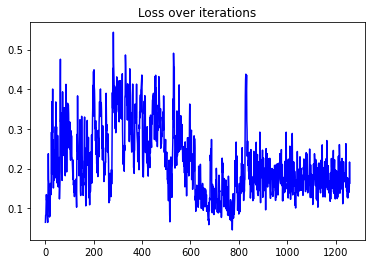

Peforming update on model with batch_size - 32
Iteration 1260 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1261 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1262 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1263 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1264 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1265 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1266 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1267 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1268 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1269 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1270 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1271 - batch size: 32
Peforming update on model with batch_size - 32
Itera

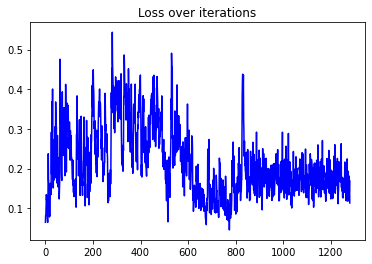

Peforming update on model with batch_size - 32
Iteration 1280 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1281 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1282 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1283 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1284 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1285 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1286 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1287 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1288 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1289 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1290 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1291 - batch size: 32
Peforming update on model with batch_size - 32
Itera

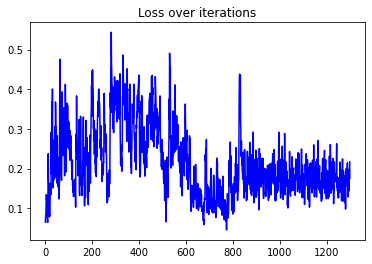

Peforming update on model with batch_size - 32
Iteration 1300 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1301 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1302 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1303 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1304 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1305 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1306 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1307 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1308 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1309 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1310 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1311 - batch size: 32
Peforming update on model with batch_size - 32
Itera

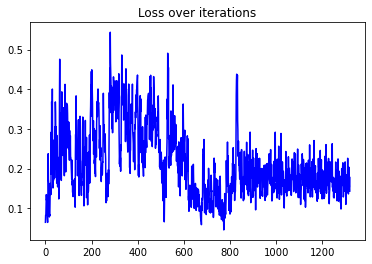

Peforming update on model with batch_size - 32
Iteration 1320 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1321 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1322 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1323 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1324 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1325 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1326 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1327 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1328 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1329 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1330 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1331 - batch size: 32
Peforming update on model with batch_size - 32
Itera

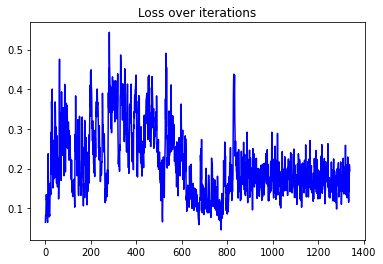

Peforming update on model with batch_size - 32
Iteration 1340 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1341 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1342 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1343 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1344 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1345 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1346 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1347 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1348 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1349 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1350 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1351 - batch size: 32
Peforming update on model with batch_size - 32
Itera

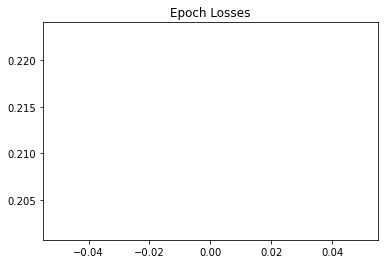

Entering epoch 1
Peforming update on model with batch_size - 32
Iteration 0 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 2 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 3 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 4 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 5 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 6 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 7 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 8 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 9 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 10 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 11 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 12 - batch s

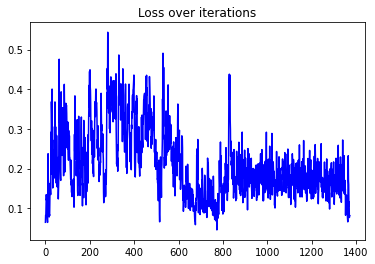

Peforming update on model with batch_size - 32
Iteration 20 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 21 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 22 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 23 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 24 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 25 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 26 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 27 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 28 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 29 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 30 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 31 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 32 - batch size: 32

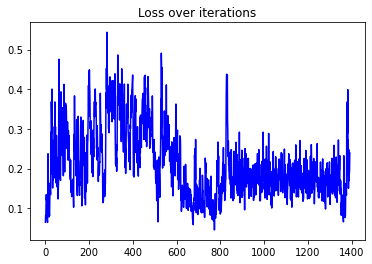

Peforming update on model with batch_size - 32
Iteration 40 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 41 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 42 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 43 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 44 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 45 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 46 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 47 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 48 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 49 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 50 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 51 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 52 - batch size: 32

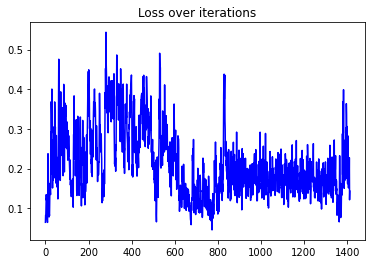

Peforming update on model with batch_size - 32
Iteration 60 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 61 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 62 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 63 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 64 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 65 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 66 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 67 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 68 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 69 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 70 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 71 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 72 - batch size: 32

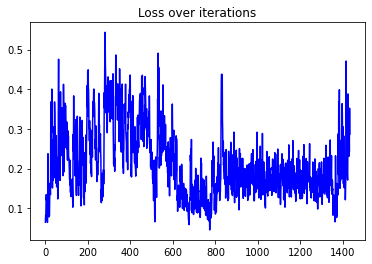

Peforming update on model with batch_size - 32
Iteration 80 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 81 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 82 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 83 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 84 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 85 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 86 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 87 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 88 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 89 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 90 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 91 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 92 - batch size: 32

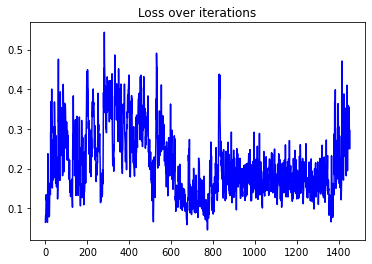

Peforming update on model with batch_size - 32
Iteration 100 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 101 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 102 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 103 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 104 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 105 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 106 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 107 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 108 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 109 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 110 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 111 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 112 - b

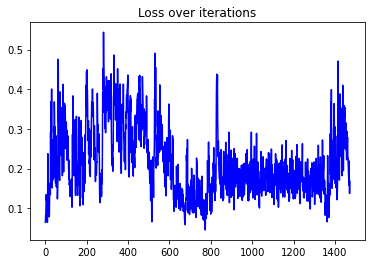

Peforming update on model with batch_size - 32
Iteration 120 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 121 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 122 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 123 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 124 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 125 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 126 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 127 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 128 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 129 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 130 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 131 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 132 - b

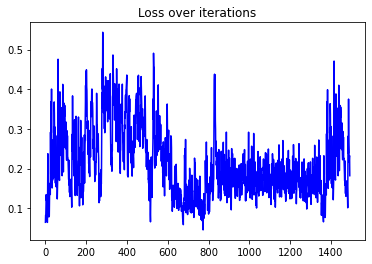

Peforming update on model with batch_size - 32
Iteration 140 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 141 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 142 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 143 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 144 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 145 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 146 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 147 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 148 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 149 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 150 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 151 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 152 - b

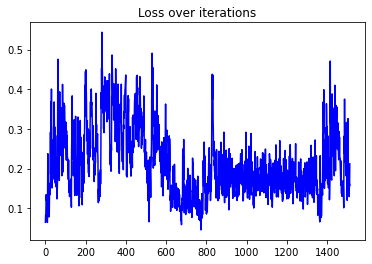

Peforming update on model with batch_size - 32
Iteration 160 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 161 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 162 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 163 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 164 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 165 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 166 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 167 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 168 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 169 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 170 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 171 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 172 - b

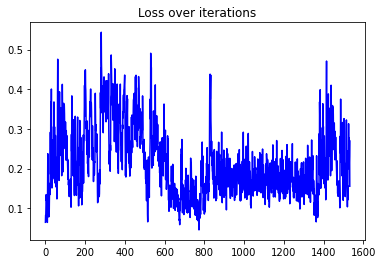

Peforming update on model with batch_size - 32
Iteration 180 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 181 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 182 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 183 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 184 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 185 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 186 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 187 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 188 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 189 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 190 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 191 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 192 - b

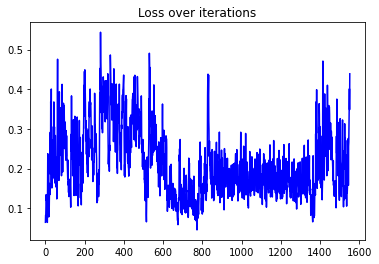

Peforming update on model with batch_size - 32
Iteration 200 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 201 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 202 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 203 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 204 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 205 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 206 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 207 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 208 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 209 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 210 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 211 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 212 - b

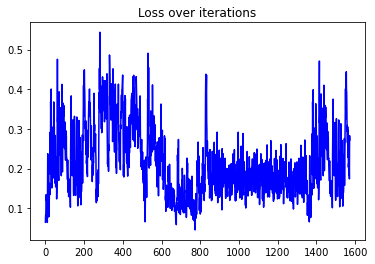

Peforming update on model with batch_size - 32
Iteration 220 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 221 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 222 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 223 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 224 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 225 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 226 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 227 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 228 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 229 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 230 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 231 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 232 - b

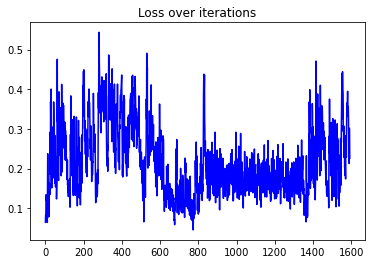

Peforming update on model with batch_size - 32
Iteration 240 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 241 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 242 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 243 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 244 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 245 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 246 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 247 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 248 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 249 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 250 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 251 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 252 - b

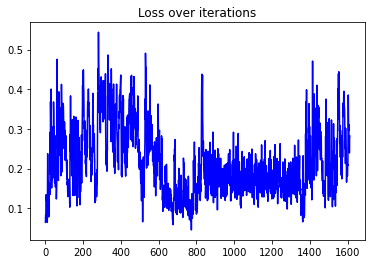

Peforming update on model with batch_size - 32
Iteration 260 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 261 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 262 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 263 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 264 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 265 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 266 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 267 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 268 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 269 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 270 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 271 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 272 - b

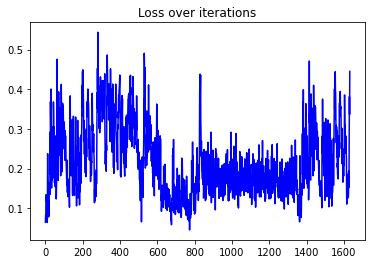

Peforming update on model with batch_size - 32
Iteration 280 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 281 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 282 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 283 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 284 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 285 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 286 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 287 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 288 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 289 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 290 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 291 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 292 - b

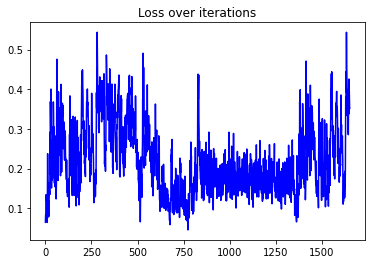

Peforming update on model with batch_size - 32
Iteration 300 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 301 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 302 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 303 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 304 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 305 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 306 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 307 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 308 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 309 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 310 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 311 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 312 - b

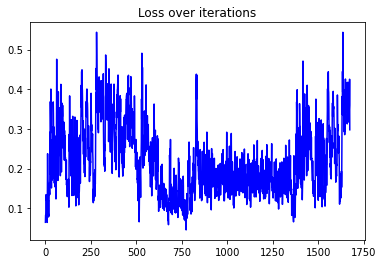

Peforming update on model with batch_size - 32
Iteration 320 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 321 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 322 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 323 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 324 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 325 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 326 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 327 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 328 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 329 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 330 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 331 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 332 - b

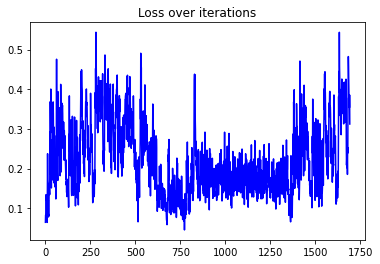

Peforming update on model with batch_size - 32
Iteration 340 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 341 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 342 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 343 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 344 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 345 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 346 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 347 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 348 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 349 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 350 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 351 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 352 - b

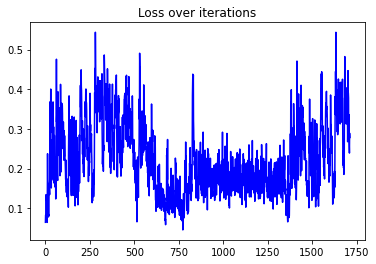

Peforming update on model with batch_size - 32
Iteration 360 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 361 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 362 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 363 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 364 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 365 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 366 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 367 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 368 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 369 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 370 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 371 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 372 - b

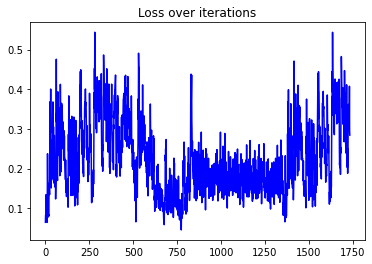

Peforming update on model with batch_size - 32
Iteration 380 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 381 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 382 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 383 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 384 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 385 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 386 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 387 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 388 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 389 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 390 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 391 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 392 - b

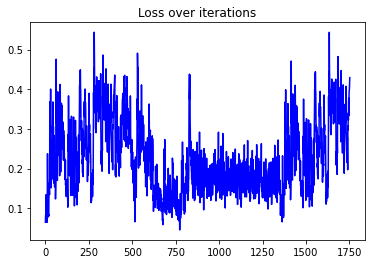

Peforming update on model with batch_size - 32
Iteration 400 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 401 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 402 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 403 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 404 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 405 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 406 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 407 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 408 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 409 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 410 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 411 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 412 - b

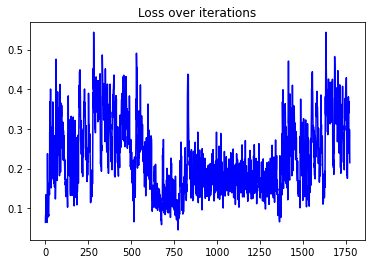

Peforming update on model with batch_size - 32
Iteration 420 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 421 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 422 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 423 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 424 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 425 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 426 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 427 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 428 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 429 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 430 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 431 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 432 - b

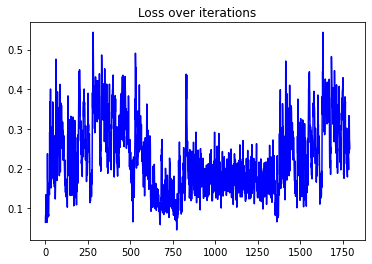

Peforming update on model with batch_size - 32
Iteration 440 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 441 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 442 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 443 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 444 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 445 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 446 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 447 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 448 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 449 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 450 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 451 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 452 - b

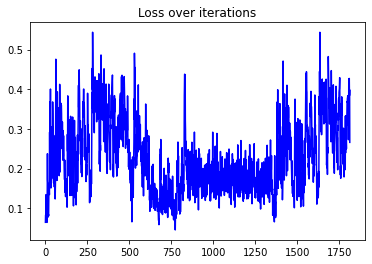

Peforming update on model with batch_size - 32
Iteration 460 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 461 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 462 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 463 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 464 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 465 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 466 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 467 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 468 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 469 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 470 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 471 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 472 - b

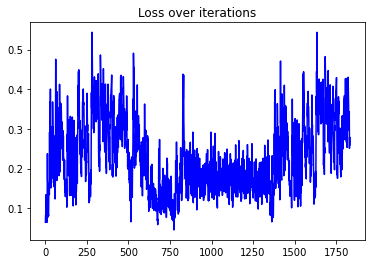

Peforming update on model with batch_size - 32
Iteration 480 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 481 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 482 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 483 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 484 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 485 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 486 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 487 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 488 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 489 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 490 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 491 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 492 - b

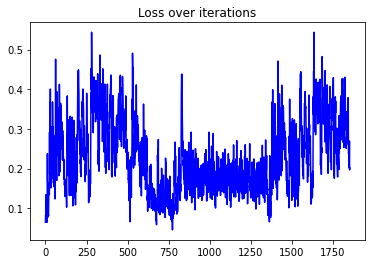

Peforming update on model with batch_size - 32
Iteration 500 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 501 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 502 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 503 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 504 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 505 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 506 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 507 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 508 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 509 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 510 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 511 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 512 - b

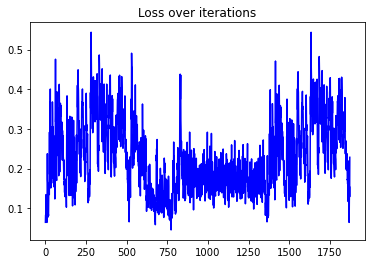

Peforming update on model with batch_size - 32
Iteration 520 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 521 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 522 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 523 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 524 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 525 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 526 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 527 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 528 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 529 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 530 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 531 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 532 - b

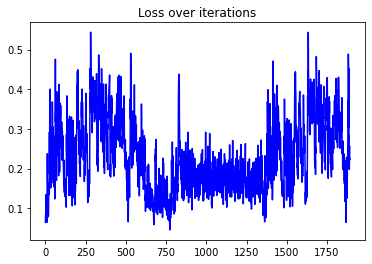

Peforming update on model with batch_size - 32
Iteration 540 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 541 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 542 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 543 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 544 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 545 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 546 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 547 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 548 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 549 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 550 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 551 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 552 - b

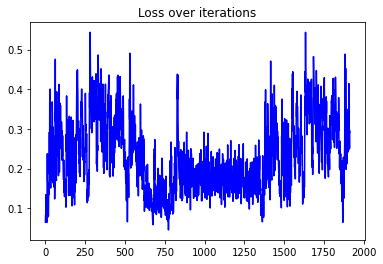

Peforming update on model with batch_size - 32
Iteration 560 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 561 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 562 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 563 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 564 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 565 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 566 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 567 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 568 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 569 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 570 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 571 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 572 - b

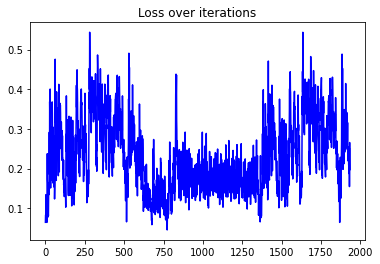

Peforming update on model with batch_size - 32
Iteration 580 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 581 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 582 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 583 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 584 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 585 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 586 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 587 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 588 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 589 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 590 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 591 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 592 - b

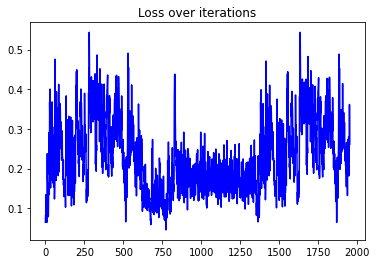

Peforming update on model with batch_size - 32
Iteration 600 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 601 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 602 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 603 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 604 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 605 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 606 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 607 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 608 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 609 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 610 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 611 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 612 - b

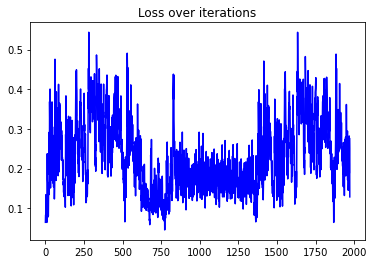

Peforming update on model with batch_size - 32
Iteration 620 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 621 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 622 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 623 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 624 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 625 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 626 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 627 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 628 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 629 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 630 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 631 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 632 - b

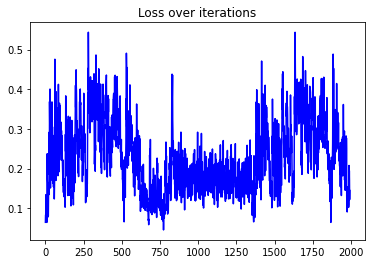

Peforming update on model with batch_size - 32
Iteration 640 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 641 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 642 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 643 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 644 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 645 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 646 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 647 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 648 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 649 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 650 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 651 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 652 - b

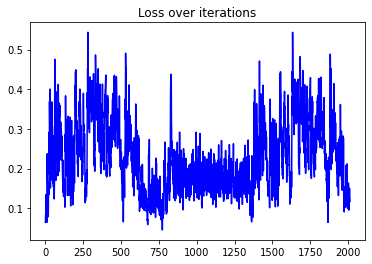

Peforming update on model with batch_size - 32
Iteration 660 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 661 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 662 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 663 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 664 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 665 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 666 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 667 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 668 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 669 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 670 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 671 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 672 - b

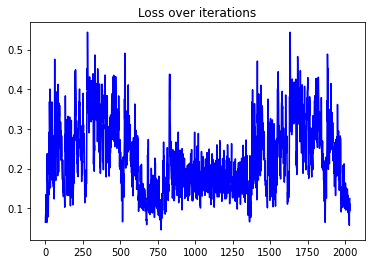

Peforming update on model with batch_size - 32
Iteration 680 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 681 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 682 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 683 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 684 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 685 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 686 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 687 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 688 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 689 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 690 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 691 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 692 - b

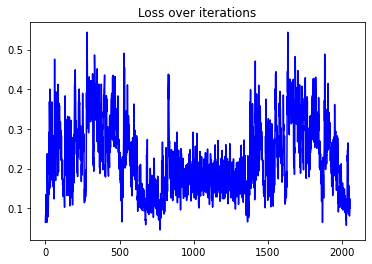

Peforming update on model with batch_size - 32
Iteration 700 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 701 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 702 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 703 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 704 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 705 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 706 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 707 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 708 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 709 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 710 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 711 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 712 - b

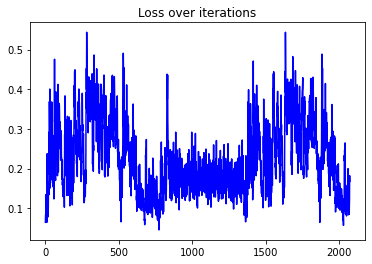

Peforming update on model with batch_size - 32
Iteration 720 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 721 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 722 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 723 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 724 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 725 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 726 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 727 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 728 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 729 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 730 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 731 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 732 - b

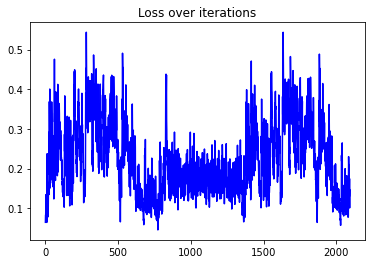

Peforming update on model with batch_size - 32
Iteration 740 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 741 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 742 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 743 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 744 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 745 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 746 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 747 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 748 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 749 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 750 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 751 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 752 - b

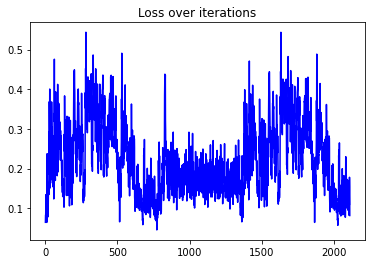

Peforming update on model with batch_size - 32
Iteration 760 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 761 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 762 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 763 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 764 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 765 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 766 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 767 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 768 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 769 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 770 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 771 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 772 - b

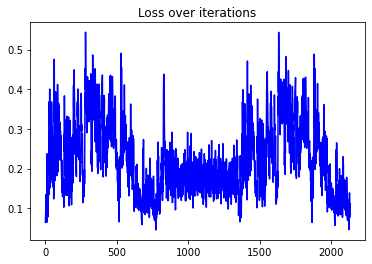

Peforming update on model with batch_size - 32
Iteration 780 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 781 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 782 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 783 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 784 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 785 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 786 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 787 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 788 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 789 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 790 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 791 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 792 - b

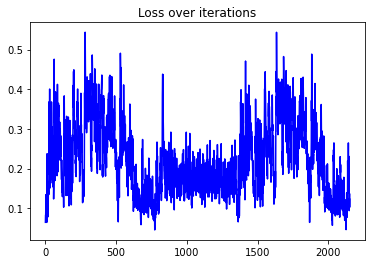

Peforming update on model with batch_size - 32
Iteration 800 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 801 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 802 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 803 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 804 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 805 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 806 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 807 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 808 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 809 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 810 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 811 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 812 - b

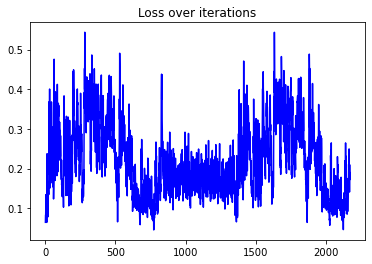

Peforming update on model with batch_size - 32
Iteration 820 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 821 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 822 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 823 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 824 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 825 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 826 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 827 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 828 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 829 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 830 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 831 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 832 - b

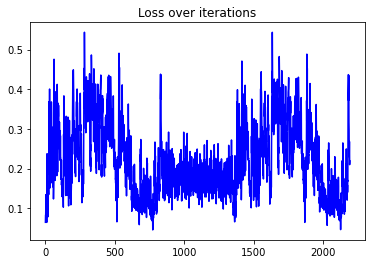

Peforming update on model with batch_size - 32
Iteration 840 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 841 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 842 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 843 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 844 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 845 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 846 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 847 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 848 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 849 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 850 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 851 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 852 - b

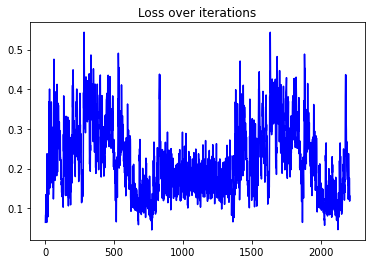

Peforming update on model with batch_size - 32
Iteration 860 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 861 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 862 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 863 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 864 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 865 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 866 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 867 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 868 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 869 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 870 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 871 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 872 - b

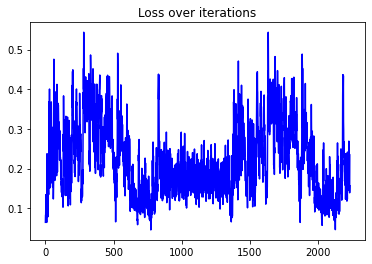

Peforming update on model with batch_size - 32
Iteration 880 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 881 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 882 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 883 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 884 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 885 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 886 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 887 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 888 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 889 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 890 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 891 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 892 - b

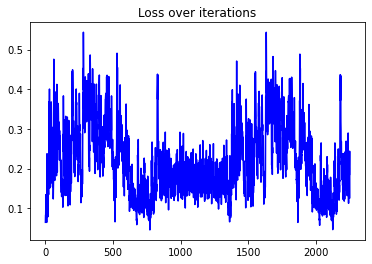

Peforming update on model with batch_size - 32
Iteration 900 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 901 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 902 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 903 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 904 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 905 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 906 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 907 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 908 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 909 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 910 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 911 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 912 - b

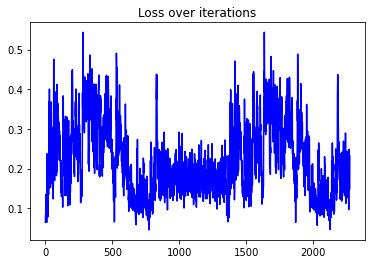

Peforming update on model with batch_size - 32
Iteration 920 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 921 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 922 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 923 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 924 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 925 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 926 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 927 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 928 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 929 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 930 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 931 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 932 - b

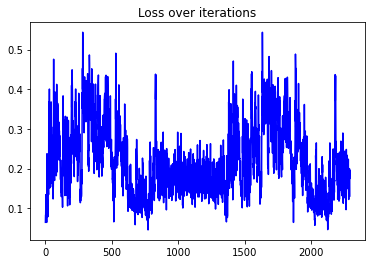

Peforming update on model with batch_size - 32
Iteration 940 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 941 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 942 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 943 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 944 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 945 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 946 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 947 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 948 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 949 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 950 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 951 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 952 - b

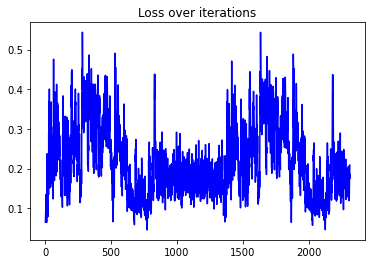

Peforming update on model with batch_size - 32
Iteration 960 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 961 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 962 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 963 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 964 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 965 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 966 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 967 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 968 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 969 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 970 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 971 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 972 - b

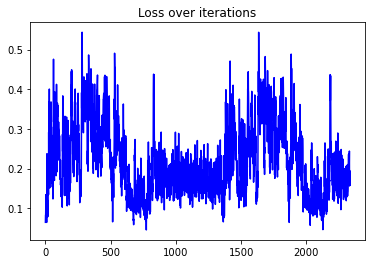

Peforming update on model with batch_size - 32
Iteration 980 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 981 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 982 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 983 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 984 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 985 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 986 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 987 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 988 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 989 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 990 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 991 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 992 - b

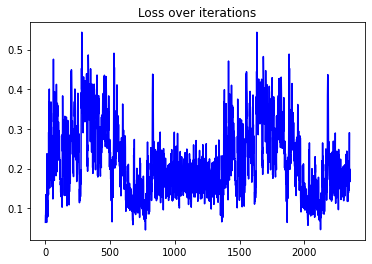

Peforming update on model with batch_size - 32
Iteration 1000 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1001 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1002 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1003 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1004 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1005 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1006 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1007 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1008 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1009 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1010 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1011 - batch size: 32
Peforming update on model with batch_size - 32
Itera

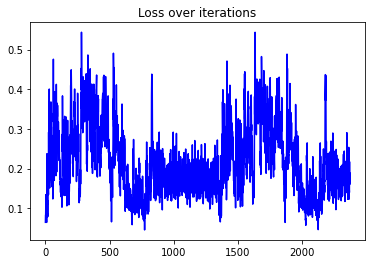

Peforming update on model with batch_size - 32
Iteration 1020 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1021 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1022 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1023 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1024 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1025 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1026 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1027 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1028 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1029 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1030 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1031 - batch size: 32
Peforming update on model with batch_size - 32
Itera

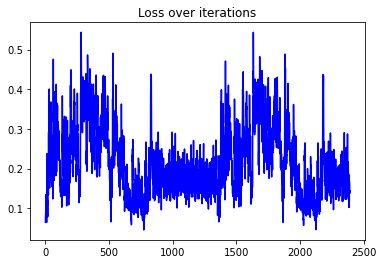

Peforming update on model with batch_size - 32
Iteration 1040 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1041 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1042 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1043 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1044 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1045 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1046 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1047 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1048 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1049 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1050 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1051 - batch size: 32
Peforming update on model with batch_size - 32
Itera

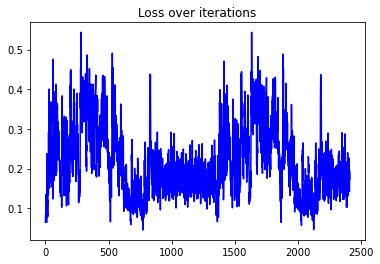

Peforming update on model with batch_size - 32
Iteration 1060 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1061 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1062 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1063 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1064 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1065 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1066 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1067 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1068 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1069 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1070 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1071 - batch size: 32
Peforming update on model with batch_size - 32
Itera

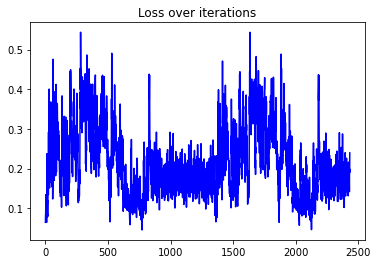

Peforming update on model with batch_size - 32
Iteration 1080 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1081 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1082 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1083 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1084 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1085 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1086 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1087 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1088 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1089 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1090 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1091 - batch size: 32
Peforming update on model with batch_size - 32
Itera

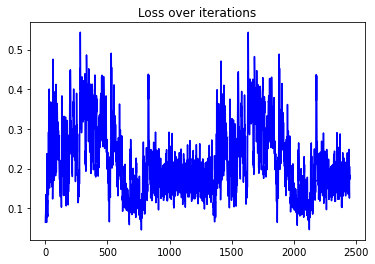

Peforming update on model with batch_size - 32
Iteration 1100 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1101 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1102 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1103 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1104 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1105 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1106 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1107 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1108 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1109 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1110 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1111 - batch size: 32
Peforming update on model with batch_size - 32
Itera

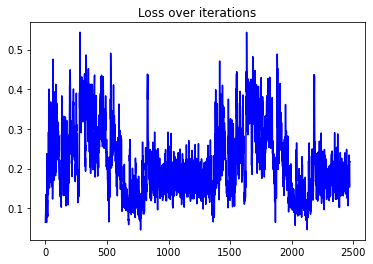

Peforming update on model with batch_size - 32
Iteration 1120 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1121 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1122 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1123 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1124 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1125 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1126 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1127 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1128 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1129 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1130 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1131 - batch size: 32
Peforming update on model with batch_size - 32
Itera

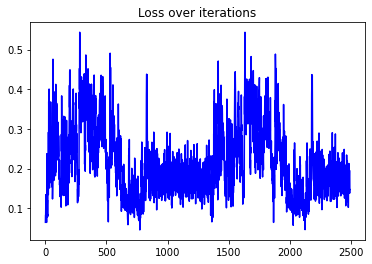

Peforming update on model with batch_size - 32
Iteration 1140 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1141 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1142 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1143 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1144 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1145 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1146 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1147 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1148 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1149 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1150 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1151 - batch size: 32
Peforming update on model with batch_size - 32
Itera

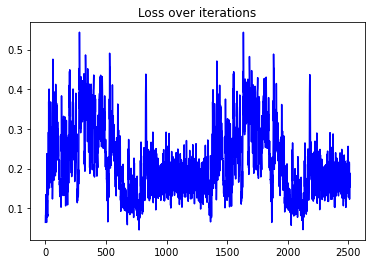

Peforming update on model with batch_size - 32
Iteration 1160 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1161 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1162 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1163 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1164 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1165 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1166 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1167 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1168 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1169 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1170 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1171 - batch size: 32
Peforming update on model with batch_size - 32
Itera

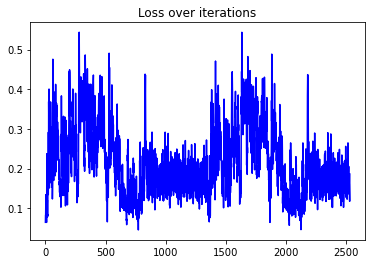

Peforming update on model with batch_size - 32
Iteration 1180 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1181 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1182 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1183 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1184 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1185 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1186 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1187 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1188 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1189 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1190 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1191 - batch size: 32
Peforming update on model with batch_size - 32
Itera

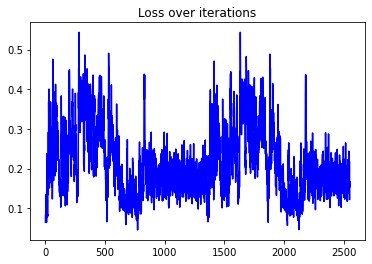

Peforming update on model with batch_size - 32
Iteration 1200 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1201 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1202 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1203 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1204 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1205 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1206 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1207 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1208 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1209 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1210 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1211 - batch size: 32
Peforming update on model with batch_size - 32
Itera

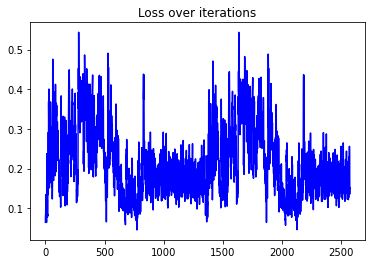

Peforming update on model with batch_size - 32
Iteration 1220 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1221 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1222 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1223 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1224 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1225 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1226 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1227 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1228 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1229 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1230 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1231 - batch size: 32
Peforming update on model with batch_size - 32
Itera

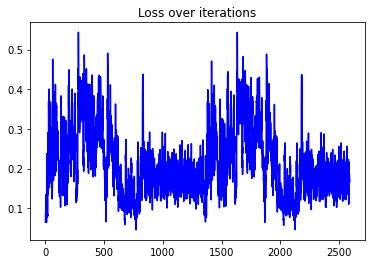

Peforming update on model with batch_size - 32
Iteration 1240 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1241 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1242 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1243 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1244 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1245 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1246 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1247 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1248 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1249 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1250 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1251 - batch size: 32
Peforming update on model with batch_size - 32
Itera

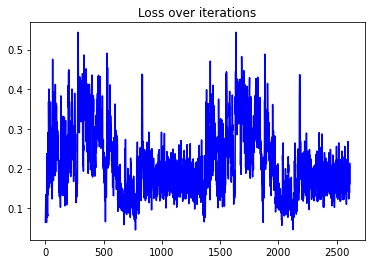

Peforming update on model with batch_size - 32
Iteration 1260 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1261 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1262 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1263 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1264 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1265 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1266 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1267 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1268 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1269 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1270 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1271 - batch size: 32
Peforming update on model with batch_size - 32
Itera

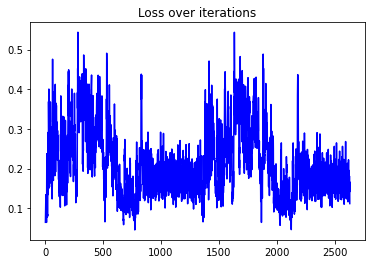

Peforming update on model with batch_size - 32
Iteration 1280 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1281 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1282 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1283 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1284 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1285 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1286 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1287 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1288 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1289 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1290 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1291 - batch size: 32
Peforming update on model with batch_size - 32
Itera

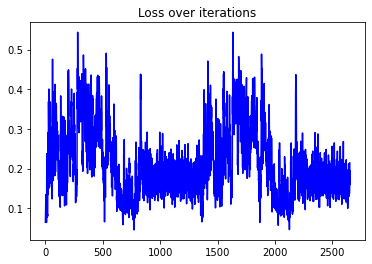

Peforming update on model with batch_size - 32
Iteration 1300 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1301 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1302 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1303 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1304 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1305 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1306 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1307 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1308 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1309 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1310 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1311 - batch size: 32
Peforming update on model with batch_size - 32
Itera

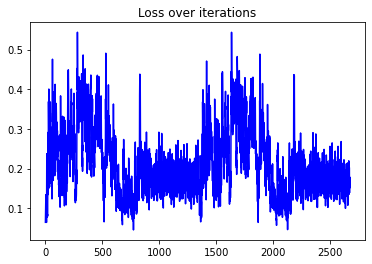

Peforming update on model with batch_size - 32
Iteration 1320 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1321 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1322 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1323 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1324 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1325 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1326 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1327 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1328 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1329 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1330 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1331 - batch size: 32
Peforming update on model with batch_size - 32
Itera

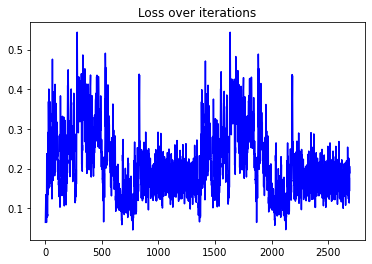

Peforming update on model with batch_size - 32
Iteration 1340 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1341 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1342 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1343 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1344 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1345 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1346 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1347 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1348 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1349 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1350 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1351 - batch size: 32
Peforming update on model with batch_size - 32
Itera

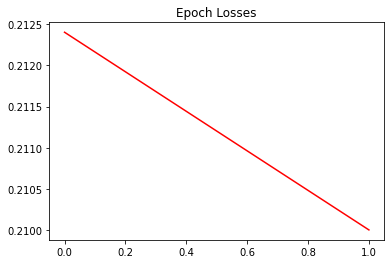

Entering epoch 2
Peforming update on model with batch_size - 32
Iteration 0 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 1 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 2 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 3 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 4 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 5 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 6 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 7 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 8 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 9 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 10 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 11 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 12 - batch s

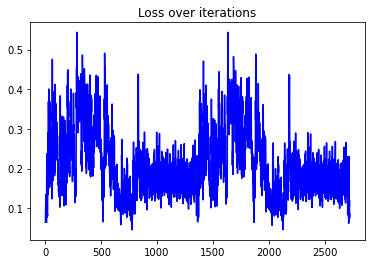

Peforming update on model with batch_size - 32
Iteration 20 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 21 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 22 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 23 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 24 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 25 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 26 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 27 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 28 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 29 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 30 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 31 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 32 - batch size: 32

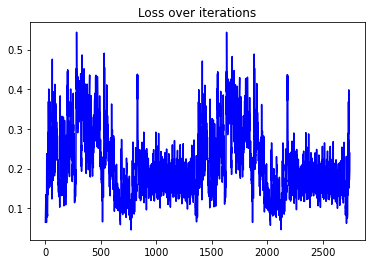

Peforming update on model with batch_size - 32
Iteration 40 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 41 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 42 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 43 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 44 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 45 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 46 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 47 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 48 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 49 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 50 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 51 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 52 - batch size: 32

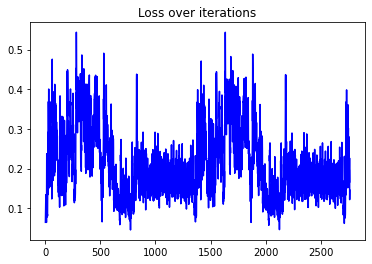

Peforming update on model with batch_size - 32
Iteration 60 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 61 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 62 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 63 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 64 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 65 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 66 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 67 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 68 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 69 - batch size: 32
Peforming update on model with batch_size - 32
Iteration 70 - batch size: 32


KeyboardInterrupt: 

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
train(EPOCHS, dataset, BATCH_LEN, model, optimizer, criterion)

#### Lets see the results


tensor([[80.0624, 65.8758, 67.0400,  ..., 78.0135, 71.3976, 93.1061],
        [64.1297, 64.4814, 74.4480,  ..., 75.8463, 66.2291, 70.7437],
        [55.5121, 54.8840, 58.7106,  ..., 69.6389, 63.2932, 70.4920],
        ...,
        [54.3015, 58.8667, 61.3452,  ..., 60.9829, 60.7885, 56.3898],
        [59.6632, 54.7159, 57.0995,  ..., 62.0646, 65.1311, 66.6574],
        [78.1604, 67.1153, 60.4119,  ..., 65.2296, 68.4939, 79.1296]])
tensor([[69.8951, 67.3787, 66.1303,  ..., 75.6093, 75.7727, 79.8236],
        [62.1567, 61.1045, 60.6442,  ..., 71.0357, 74.7200, 66.5328],
        [59.4681, 53.7154, 53.2252,  ..., 60.7227, 55.6668, 59.6336],
        ...,
        [54.9275, 62.6212, 62.2819,  ..., 59.4543, 56.0162, 53.3739],
        [55.6034, 56.8954, 52.8893,  ..., 58.9997, 55.8250, 62.7674],
        [71.9544, 63.1113, 62.6997,  ..., 68.3029, 62.8659, 77.3049]])
tensor([[73.2017, 67.5700, 66.4372,  ..., 72.4031, 71.2059, 84.5529],
        [64.3486, 65.6431, 66.4483,  ..., 69.5323, 64.2729, 77

tensor([[43.4383, 34.8823, 34.7589,  ..., 46.5438, 40.0051, 58.1257],
        [30.9308, 37.4834, 45.7572,  ..., 47.7314, 38.1536, 41.5653],
        [30.9097, 33.5840, 37.2315,  ..., 45.2597, 37.7038, 45.1031],
        ...,
        [32.7399, 37.1876, 44.1180,  ..., 46.1642, 45.9438, 40.9964],
        [38.0606, 33.5478, 38.7209,  ..., 44.9719, 48.8786, 48.7784],
        [51.6787, 44.9222, 40.4835,  ..., 48.3604, 50.1563, 59.7266]])
tensor([[30.0343, 35.8595, 34.9368,  ..., 46.3965, 44.2476, 45.1889],
        [30.0143, 36.2682, 34.5098,  ..., 42.9583, 44.9848, 37.1501],
        [34.4023, 28.6932, 26.7940,  ..., 37.1596, 31.6361, 34.1165],
        ...,
        [32.0870, 45.6396, 45.6389,  ..., 45.5007, 42.5332, 38.6847],
        [32.9766, 37.0354, 34.4050,  ..., 42.9407, 40.1296, 46.1687],
        [45.6646, 42.1450, 42.6389,  ..., 51.2257, 46.3369, 57.8346]])
tensor([[35.5175, 36.2327, 32.6925,  ..., 41.3766, 39.4640, 49.5662],
        [31.2385, 40.5299, 37.8003,  ..., 40.4063, 36.5795, 45

tensor([[43.1255, 34.6081, 34.4824,  ..., 46.2319, 39.6810, 57.7598],
        [30.6581, 37.2752, 45.4900,  ..., 47.4715, 37.8818, 41.2682],
        [30.7196, 33.4152, 37.0912,  ..., 45.0411, 37.4742, 44.8631],
        ...,
        [32.6741, 37.1117, 44.0420,  ..., 46.2078, 45.9833, 41.0271],
        [37.9817, 33.4710, 38.6381,  ..., 45.0216, 48.9140, 48.8164],
        [51.5846, 44.8271, 40.3905,  ..., 48.3977, 50.1971, 59.7650]])
tensor([[29.7500, 35.6155, 34.6598,  ..., 46.1334, 43.9367, 44.8581],
        [29.7747, 36.0871, 34.2922,  ..., 42.7232, 44.7086, 36.8945],
        [34.1963, 28.5516, 26.6096,  ..., 36.9944, 31.4419, 33.9138],
        ...,
        [32.0158, 45.5720, 45.5671,  ..., 45.5402, 42.5610, 38.7164],
        [32.9027, 36.9552, 34.3431,  ..., 42.9756, 40.1553, 46.1979],
        [45.5726, 42.0590, 42.5403,  ..., 51.2683, 46.3647, 57.8700]])
tensor([[35.2067, 35.9700, 32.3759,  ..., 41.0980, 39.1757, 49.2247],
        [30.9566, 40.3241, 37.5350,  ..., 40.1733, 36.3605, 45

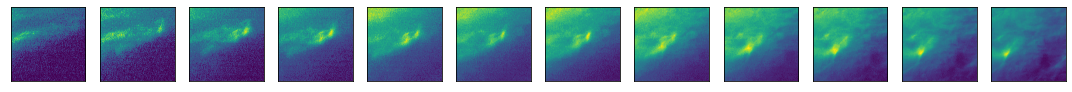

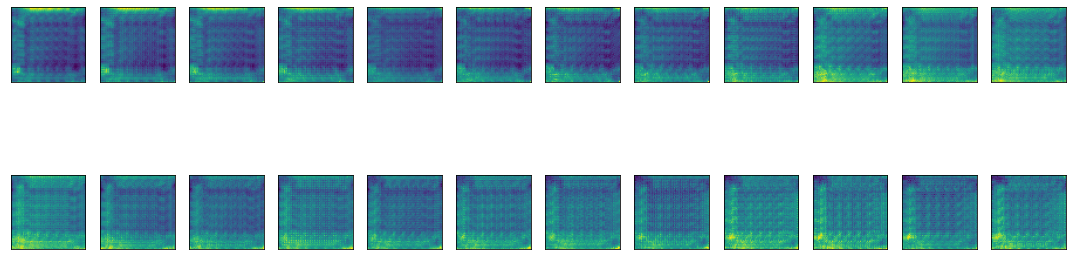

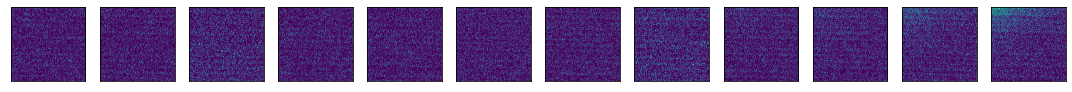

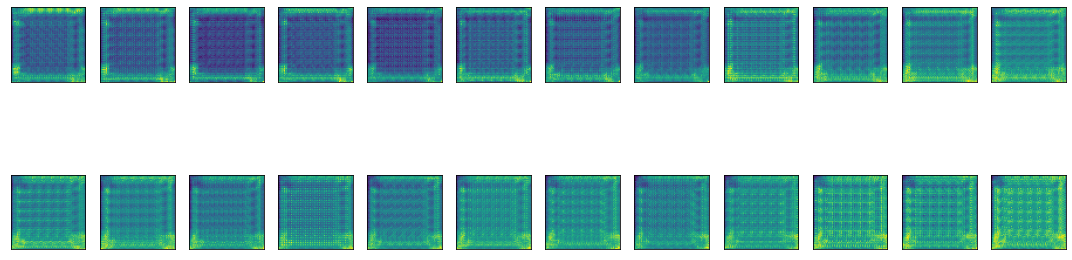

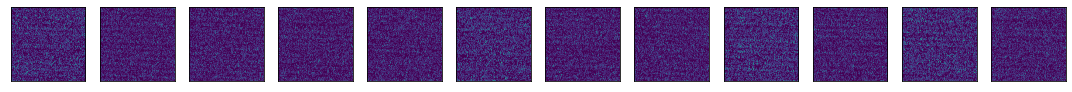

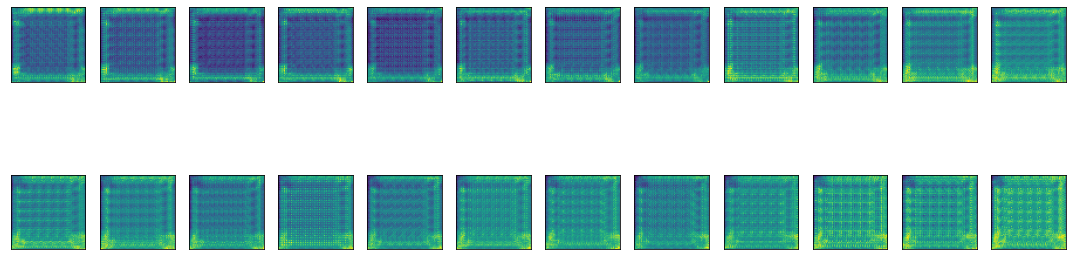

In [31]:
model.eval()
garbo = [dataset[i] for i in range(10, 13)]
for i, (features, targets) in enumerate(garbo):
    if i == 6:
        break
    
    fig, axs = plt.subplots(1, 12, figsize=(15, 3))
    for f_no, ax in enumerate(axs):
        ax.imshow(features[f_no], cmap='viridis')
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
    fig.tight_layout()
    fig.show()
    
    features = torch.tensor(features).unsqueeze(0).to(device)
    predictions = model(features)
    fig, axs = plt.subplots(2, 12, figsize=(15, 6))
    predictions = predictions.squeeze()
    predictions = predictions.detach().cpu()
    p_no = 0
    for chonky in axs:
        for ax in chonky:
            ax.imshow(predictions[p_no], cmap='viridis')
            ax.get_yaxis().set_visible(False)
            ax.get_xaxis().set_visible(False)
            print(predictions[p_no])
            p_no += 1
    fig.tight_layout()
    
    fig.show()

In [10]:
model.load_state_dict(torch.load(os.path.join(dir_to_save, 'epoch-1_iteration-1339_loss-0.1706679254770279'), map_location=device))

<All keys matched successfully>

In [17]:
garbo = model.transformer.in_pe.expand(5, -1, -1)
garbo.device

device(type='cuda', index=0)

In [14]:
print(torch.mean(model.process.q_out))

tensor(-1.7162e-05, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
plt.plot(losses, 'b-')
plt.set_title("THe losses wow")
plt.show()